In [1]:
import os 
import sys

## Ising Hamiltonian

## cn0

In [2]:
Ni = range(2,21,2)

Ising_normal = [[] for _ in range(1,11)]
Ising_MM = [[] for _ in range(1, 11)]
for i in range(1,11):
    path = os.path.abspath(os.path.join("Ising_Results", "cn0_itr2_Ising_normal{}.txt".format(i)))
    with open(path, 'r') as f:
        for line in f.readlines()[1:]:
            words = line.split()
            n = int(words[0])//2 - 1
            Ising_normal[n].append(float(words[1]))
            
    path = os.path.abspath(os.path.join("Ising_Results", "cn0_itr2_Ising_MM{}.txt".format(i)))
    with open(path, 'r') as f:
        for line in f.readlines()[1:]:
            words = line.split()
            n = int(words[0])//2 - 1
            Ising_MM[n].append(float(words[1]))

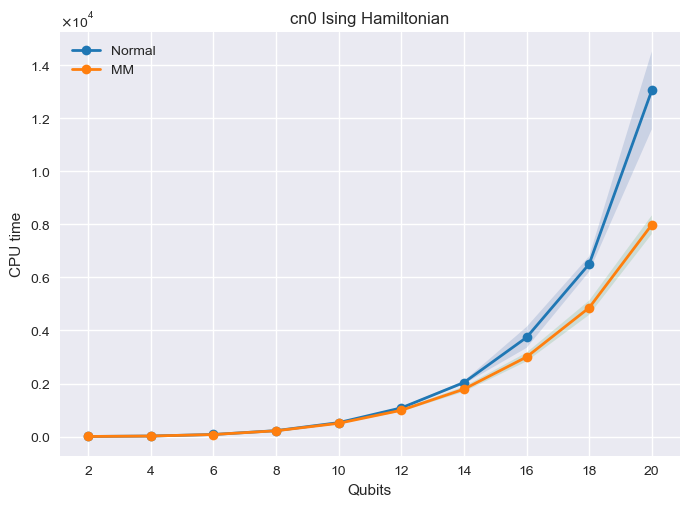

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

yn = np.array([np.mean(Ising_normal[i]) for i in range(10)])
yn_std = np.array([np.std(Ising_normal[i]) for i in range(10)])
ym = np.array([np.mean(Ising_MM[i]) for i in range(10)])
ym_std = np.array([np.std(Ising_MM[i]) for i in range(10)])


fig, ax = plt.subplots(1, 1)
plt.style.use("seaborn")
#clrs = sns.color_palette("husl", 5)
#with sns.axes_style("darkgrid"):
ax.plot(Ni, yn, label="Normal", marker='o',color="tab:blue", linewidth=2)
ax.fill_between(Ni, yn-yn_std, yn+yn_std, alpha=0.2)
ax.plot(Ni, ym, label="MM", marker='o', color="tab:orange",linewidth=2)
ax.fill_between(Ni, ym-ym_std, ym+ym_std, alpha=0.2)


    

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

plt.xticks(Ni) 
plt.legend(loc='upper left')
plt.ylabel("CPU time")
plt.xlabel("Qubits")
plt.title("cn0 Ising Hamiltonian")
plt.show()
#fig.savefig(os.path.join("Figures", "ISING.eps"))

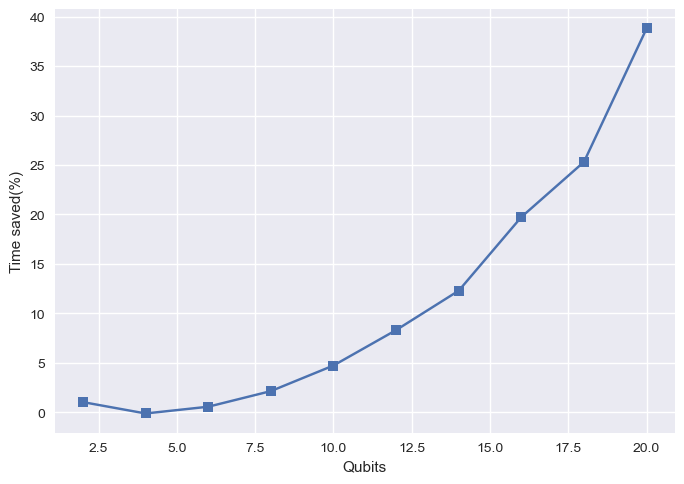

In [4]:
S = []
for i in range(10):
    S.append(100*(yn[i] - ym[i])/yn[i])

with sns.axes_style("darkgrid"):    
    plt.plot(Ni, S, marker='s')
    #plt.title("Time saved(%)")
    plt.ylabel("Time saved(%)")
    plt.xlabel("Qubits")
    plt.show()
#fig.savefig(os.path.join("Figures", "ISING_DIFF.eps"))

## Molecular Hamiltonian

### 1. QWC

In [5]:
mol = ['H2', 'H4', 'LiH', 'H2O']
N = [4, 8, 12, 14]


QWC_normal = [[] for _ in N]
QWC_MM = [[] for _ in N]
for i in range(1,11):
    path = os.path.abspath(os.path.join("Molecule_Results", "cn0_Molecular_QWC_normal{}.txt".format(i)))
    with open(path, 'r') as f:
        j = 0
        for line in f.readlines()[1:]:
            words = line.split()
            QWC_normal[j].append(float(words[2]))
            j += 1
    
    path = os.path.abspath(os.path.join("Molecule_Results", "cn0_Molecular_QWC_MM{}.txt".format(i)))
    with open(path, 'r') as f:
        j = 0
        for line in f.readlines()[1:]:
            words = line.split()
            QWC_MM[j].append(float(words[2]))
            j += 1

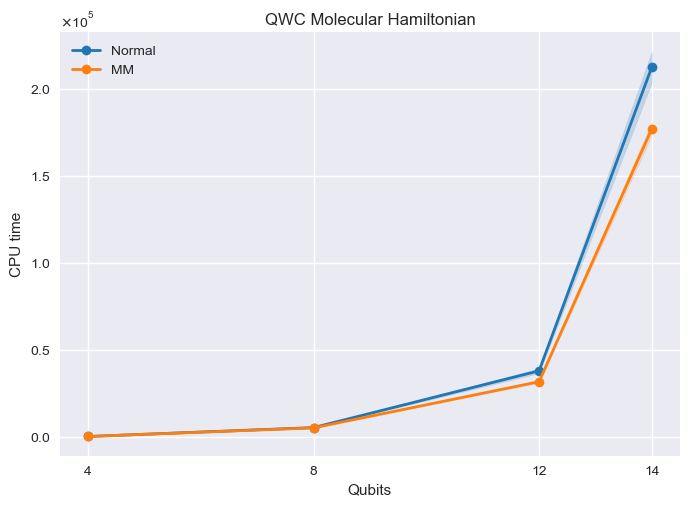

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

yn = np.array([np.mean(QWC_normal[i]) for i in range(4)])
yn_std = np.array([np.std(QWC_normal[i]) for i in range(4)])
ym = np.array([np.mean(QWC_MM[i]) for i in range(4)])
ym_std = np.array([np.std(QWC_MM[i]) for i in range(4)])


fig, ax = plt.subplots(1, 1)
plt.style.use("seaborn")
#clrs = sns.color_palette("husl", 5)
#with sns.axes_style("darkgrid"):
ax.plot(N, yn, label="Normal", marker='o',color="tab:blue", linewidth=2)
ax.fill_between(N, yn-yn_std, yn+yn_std, color="tab:blue", alpha=0.2)
ax.plot(N, ym, label="MM", marker='o', color="tab:orange",linewidth=2)
ax.fill_between(N, ym-ym_std, ym+ym_std, color="tab:orange", alpha=0.2)


    

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

plt.xticks(N) 
plt.legend(loc='upper left')
plt.ylabel("CPU time")
plt.xlabel("Qubits")
plt.title("QWC Molecular Hamiltonian")
plt.show()
#fig.savefig(os.path.join("Figures", "MOL_QWC.eps"))

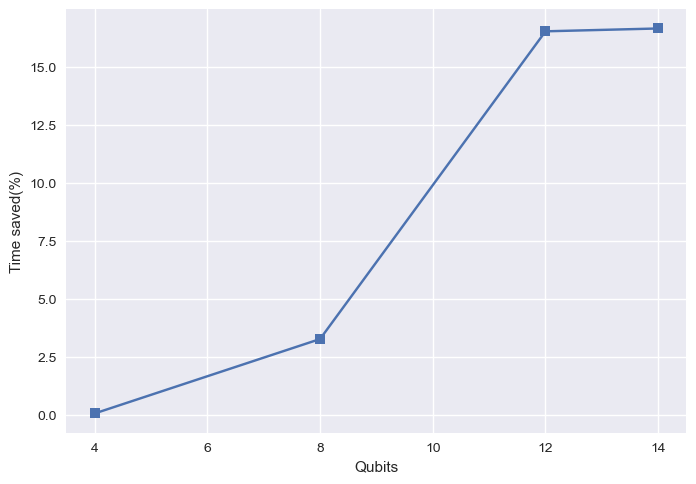

In [7]:
S = []
for i in range(4):
    S.append(100*(yn[i] - ym[i])/yn[i])

with sns.axes_style("darkgrid"):    
    plt.plot(N, S, marker='s')
    #plt.title("Time saved(%)")
    plt.ylabel("Time saved(%)")
    plt.xlabel("Qubits")
    plt.show()
#fig.savefig(os.path.join("Figures", "MOL_QWC_DIFF.eps"))

### 2.GC

In [8]:
mol = ['H2', 'H4', 'LiH', 'H2O']
N = [4, 8, 12, 14]


GC_normal = [[] for _ in N]
GC_MM = [[] for _ in N]
for i in range(1,11):
    path = os.path.abspath(os.path.join("Molecule_Results", "cn0_Molecular_GC_normal{}.txt".format(i)))
    with open(path, 'r') as f:
        j = 0
        for line in f.readlines()[1:]:
            words = line.split()
            GC_normal[j].append(float(words[2]))
            j += 1
    
    path = os.path.abspath(os.path.join("Molecule_Results", "cn0_Molecular_GC_MM{}.txt".format(i)))
    with open(path, 'r') as f:
        j = 0
        for line in f.readlines()[1:]:
            words = line.split()
            GC_MM[j].append(float(words[2]))
            j += 1

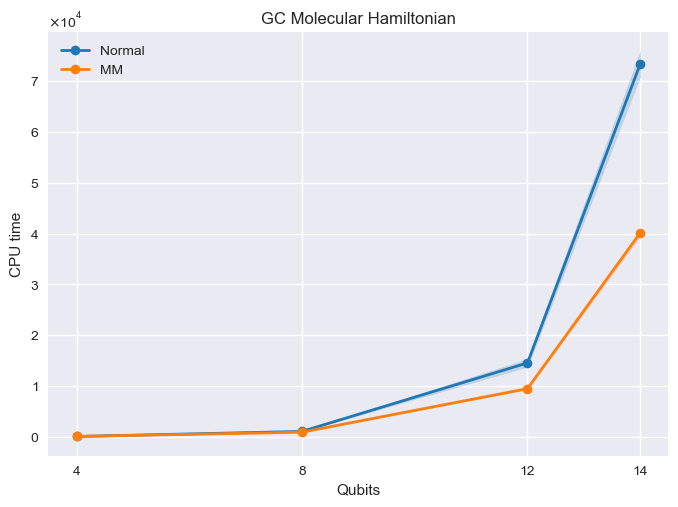

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

yn = np.array([np.mean(GC_normal[i]) for i in range(4)])
yn_std = np.array([np.std(GC_normal[i]) for i in range(4)])
ym = np.array([np.mean(GC_MM[i]) for i in range(4)])
ym_std = np.array([np.std(GC_MM[i]) for i in range(4)])


fig, ax = plt.subplots(1, 1)
plt.style.use("seaborn")
#clrs = sns.color_palette("husl", 5)
#with sns.axes_style("darkgrid"):
ax.plot(N, yn, label="Normal", marker='o',color="tab:blue", linewidth=2)
ax.fill_between(N, yn-yn_std, yn+yn_std, color="tab:blue", alpha=0.2)
ax.plot(N, ym, label="MM", marker='o', color="tab:orange",linewidth=2)
ax.fill_between(N, ym-ym_std, ym+ym_std, color="tab:orange", alpha=0.2)


    

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

plt.xticks(N) 
plt.legend(loc='upper left')
plt.ylabel("CPU time")
plt.xlabel("Qubits")
plt.title("GC Molecular Hamiltonian")
plt.show()
#fig.savefig(os.path.join("Figures", "MOL_GC.eps"))

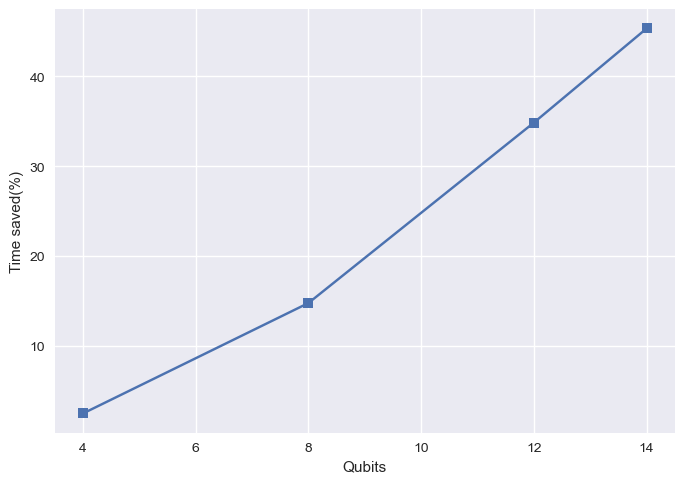

In [10]:
S = []
for i in range(4):
    S.append(100*(yn[i] - ym[i])/yn[i])

with sns.axes_style("darkgrid"):    
    plt.plot(N, S, marker='s')
    #plt.title("Time saved(%)")
    plt.ylabel("Time saved(%)")
    plt.xlabel("Qubits")
    plt.show()
#fig.savefig(os.path.join("Figures", "MOL_GC_DIFF.eps"))